# `CLOUD.jl` - 2D linear advection

In [127]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_collapsed_2D/";

Define the physical problem

In [128]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a collapsed DGSEM of degree `p` with `M` intervals in each direction

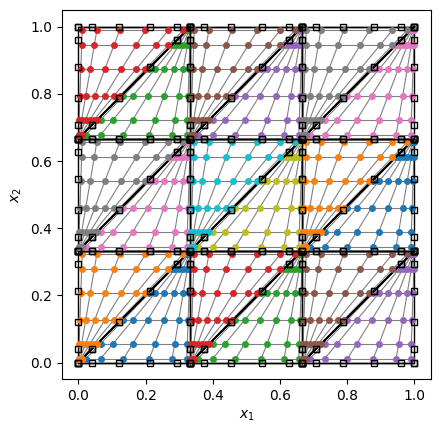

In [129]:
M = 3  # number of elements
p = 5  # degree of discretization
reference_approximation =ReferenceApproximation(
    DGSEM(p), CollapsedTri(),
    volume_quadrature_rule=(LGQuadrature(),LGQuadrature()),
    facet_quadrature_rule=LGLQuadrature(),
    N_plot=ceil(Int,50/M));
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=true, plot_facet_nodes=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [130]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, krylov=:adaptive,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            10.4s / 99.0%           10.2GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   28.1k    10.3s   100%   368μs   10.2GiB  100%    381KiB
   eval residual         505k    5.66s  54.8%  11.2μs   5.39GiB  52.8%  11.2KiB
     volume terms        505k    2.31s  22.4%  4.58μs   3.89GiB  38.1%  8.08KiB
     facet terms         505k    1.83s  17.8%  3.63μs   0.98GiB  9.59%  2.03KiB
     mass matrix solve   505k    118ms  1.15%   234ns    177MiB  1.70%     368B
   extrapolate solu...   505k    1.06s  10.3%  2.11μs   1.05GiB  10.3%  2.19KiB
   eval numerical flux   505k    569ms 

Visualize the solution

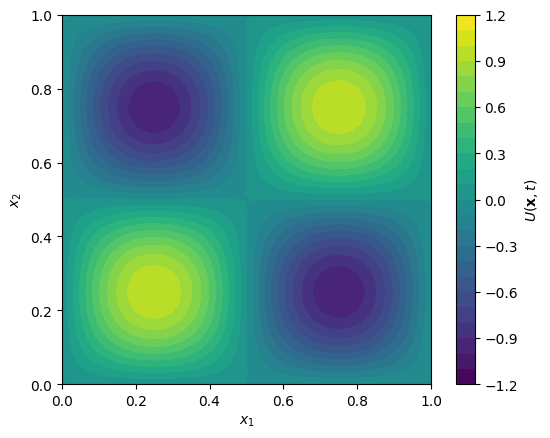

In [131]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

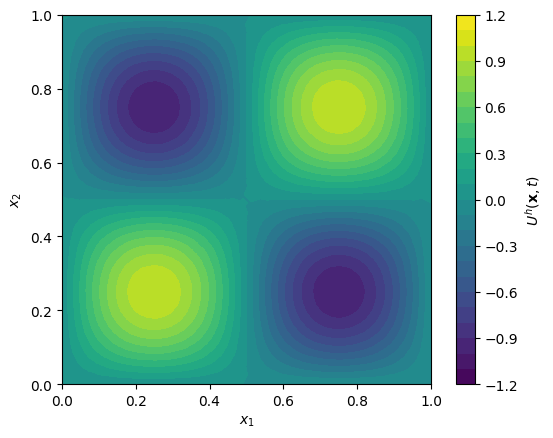

In [132]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [133]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.0004568928613666544]
Conservation (initial/final/diff):
[1.734723475976807e-17][1.9081958235744878e-16][1.734723475976807e-16]
Energy (initial/final/diff):
[0.25][0.24999482961355246][-5.170386447539421e-6]
